In [3]:
%load_ext autoreload
%autoreload 2

## Сделал:

Разметил данные (параметры - n, thresh - длина прогноза и порог чувствительности)

Запустил RF на данных, результат акураси - 0.3, то есть случайное блуждание

выбирать thresh в процентах, а не абсолютных значениях

запустить RF на окне определенной длины (длина - гиперпараметр)

автоматически подбирать window_len

## Сделать:

автоматически подбирать thresh, чтобы классы были сбалансированны или как-то еще

сравнить rf с другими моделями классификации

подбирать другие параметры rf

кросс-валидация при оценке качества



## Разбиение на классы

Предпосылки

1. Датасет нужно разделить на классы "продавать","покупать","держать"
2. Предлагается ввести "порог", через который должна переступить разница в цене в процентах за определенный период, чтобы можно было принять решение о покупке/продаже
3. Классы должны быть сбалансированы, чтобы было проще решать и оценивать решение задачи классификации

Вариант решения

https://stats.stackexchange.com/questions/387835/measuring-class-imbalance-of-a-dataset - про сбалансированность датасета

1. Введем функцию, которая в зависимости от порога дает разбитый на классы датасет

2. Посчитаем сбалансированность датасета как 
$$J(t) = \sum_i{|IdealSection - PartOfClass_i(t)|}$$
по сути, это оценка насколько датасет отличается от идеально сбалансированного (функционал оценки качества разбиения)
3. Оптимизируем $J$ по $t$

Проблема - J негладкая функция, оптимизировать сложно 

https://stackoverflow.com/questions/60725549/scipy-optimize-minimize-does-not-perform-the-optimization-convergence-norm-of

Предлагается сгладить функцию, используя сигмоиду

Это сработает для бинарного разбиения, но у меня разбиение на три класса

Тогда можно подбирать два параметра - верхняя и нижняя граница "держания" активов

In [4]:
import numpy as np
import pandas as pd
import os
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings

In [5]:
warnings.simplefilter("ignore")

In [6]:
sys.path.append('../')

In [100]:
def g(x):
    return 1./(1+np.exp(-x))

def get_label_estimation_by_diff(d, thresh, a):
    return g((d - thresh) / a)

def get_label_by_diff(d, thresh):
    if abs(d) < thresh:
        return 'hold'
    if d < 0 and d < -thresh:
        return 'sell'
    if d > 0 and d > thresh:
        return 'buy'

In [101]:
def diff_percent(df, n=10):
    diff_percent = []
    for i in range(len(df['target']) - n):
        d_p = (df['target'][i + n] - df['target'][i]) / df['target'][i] * 100
        diff_percent.append(d_p)
    diff_percent += [np.nan for i in range(n)]
    df['diff_percent'] = diff_percent
    return df

In [102]:
def make_labels(df, column, n=10, thresh=2, a=1):
    df.loc[:, 'target'] = df[column]
    df = df[['target']]
    df.loc[:, 'diff'] = df.target.diff(n)
    df = diff_percent(df, n)
    df.loc[:, 'label'] = df['diff_percent'].apply(lambda x: get_label_by_diff(x, thresh))
    df.loc[:, 'label_estimation'] = df['diff_percent'].apply(lambda x: get_label_estimation_by_diff(x, thresh, a))
    return df

In [103]:
def generate_window(df, window_len=5):
    for i in range(window_len):
        df[f'n{i + 1}'] = df['target'].shift(i + 1)
    return df

In [104]:
def prepare_data(path='../data/processed/all.csv', instrument='CL=F', n=3, thresh=1, window_len=10, a=1):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df = make_labels(df, f'{instrument} Close', n=n, thresh=thresh, a=a)
    df = generate_window(df, window_len=window_len)
    return df

In [105]:
n = 10
thresh = 3
window_len = 10
df = prepare_data(n=n, thresh=thresh, window_len=window_len, a=10)

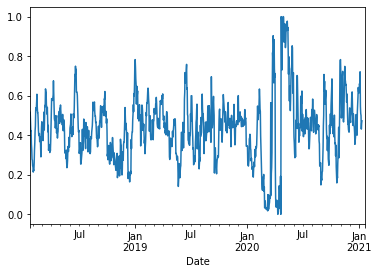

In [106]:
df['label_estimation'].plot()

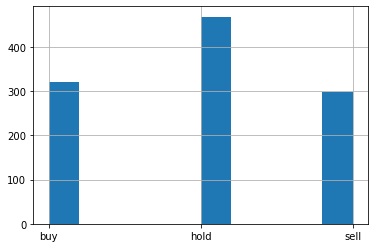

In [91]:
df.label.hist()

In [53]:
def calculate_imbalance(df, column='label_estimation', num_of_classes=3):
    N = len(df)
    ideal_param = 1 / num_of_classes
    error = 0
    for name, g in df.groupby(column):
        n_i = len(g)
        ratio = n_i / N
        error += abs(ideal_param - ratio)
    return error / N

In [57]:
from scipy.optimize import minimize

In [58]:
def get_imbalance_by_thresh(thresh, path='../data/processed/all.csv', instrument='CL=F', n=3):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df = make_labels(df, f'{instrument} Close', n=n, thresh=thresh)
    return calculate_imbalance(df)

In [65]:
def f(x):
    return 5 + x ** 2

In [66]:
minimize(f, x0=(100,))

      fun: 5.0
 hess_inv: array([[0.50000004]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([-1.24982218e-09])

In [80]:
x = np.linspace(0.5, 5, 100)
y = []
for i in x:
    y.append(get_imbalance_by_thresh(i))

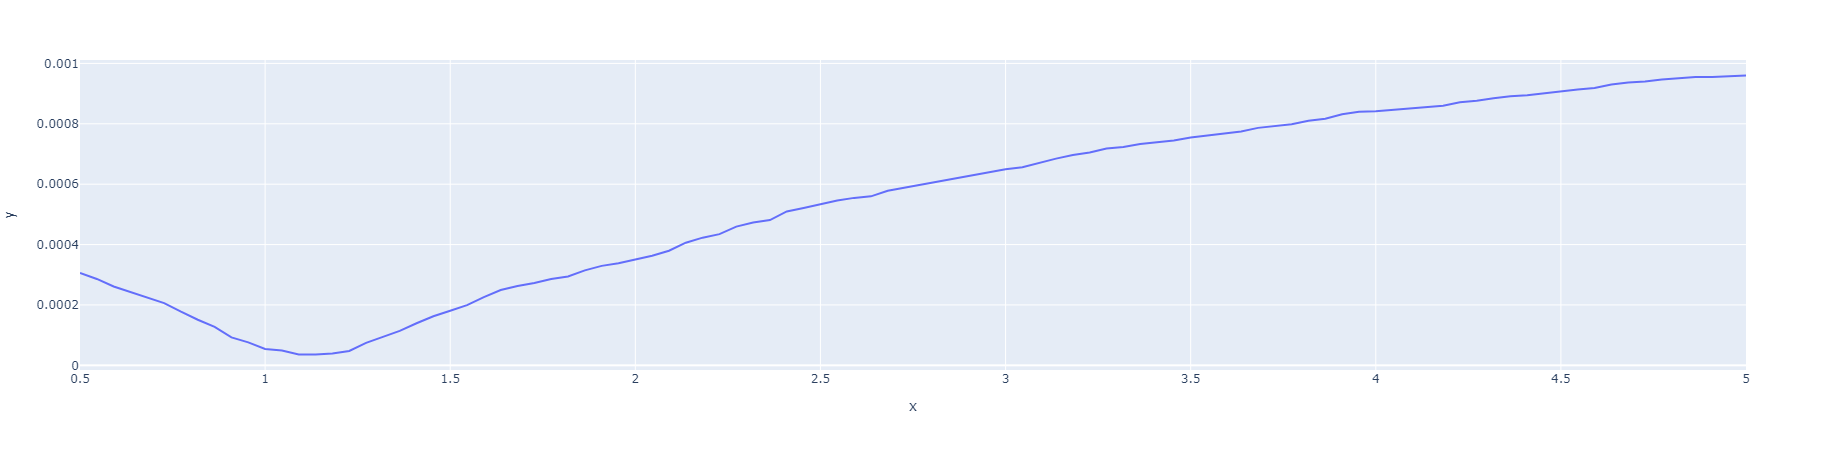

In [81]:
a = pd.DataFrame({'x': x, 'y': y})
fig = px.line(a, x='x', y='y')
fig.show()

In [87]:
res = minimize(get_imbalance_by_thresh, x0=(2,), bounds=((0.5, 5),), )
print(res)

      fun: 0.00034945059527532785
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([2.])


In [56]:
path='../data/processed/all.csv'
instrument='CL=F'
n=3
thresh=1
window_len=10
for thresh in [0.5, 1, 2, 3]:
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df = make_labels(df, f'{instrument} Close', n=n, thresh=thresh)
    print(calculate_imbalance(df))

0.0003060820249786285
5.421071287087425e-05
0.00034945059527532785
0.0006496945434832467


In [52]:
N = len(df)
ideal_param = 1 / 3

full_error = 0
for name, g in df.groupby('label'):
    n_i = len(g)
    ratio = n_i / N
    full_error +=abs(ideal_param - ratio)
print(full_error)

0.19726027397260276


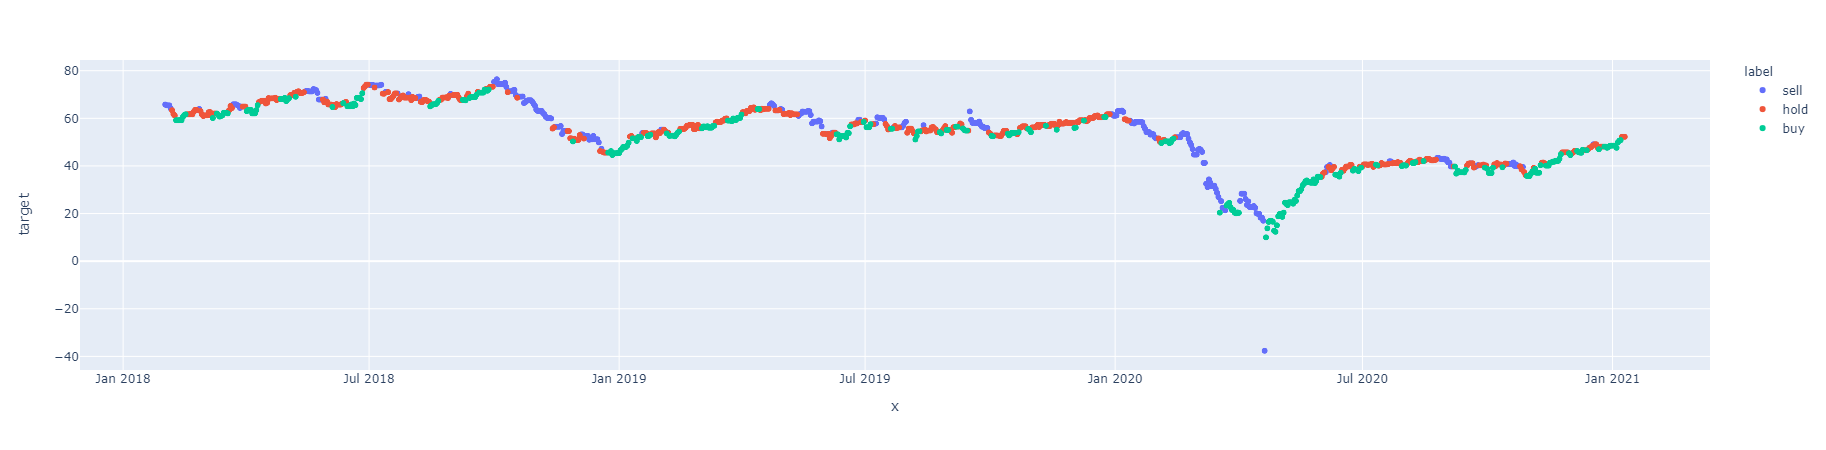

In [24]:
import plotly.express as px

fig = px.scatter(df.dropna(), x=df.dropna().index, y="target", color='label')
fig.show()

In [25]:
def train_test_split(df, train_size=0.9):
    pivot = int(len(df) * train_size)
    train = df[:pivot].dropna()
    test = df[pivot:].dropna()
    return train, test

def get_model():
    return RandomForestClassifier()

def get_x(train, test, x_columns):
    x_train = train[x_columns].to_numpy().reshape(-1, len(x_columns))
    x_test = test[x_columns].to_numpy().reshape(-1, len(x_columns))
    return x_train, x_test

def get_y(train, test):
    return train.label, test.label

def get_columns(window_len):
    return ['target', 'diff'] + [f'n{i + 1}' for i in range(window_len)]

In [29]:
def get_cv_train_test(df, train_size=0.9):
    df = df.dropna()
    start_pivot = int(len(df) * train_size)
    for pivot in range(start_pivot, len(df)):
        train = df[:pivot]
        test = df[pivot:]
        yield train, test

In [40]:
def get_accuracy(df, window_len):
#     train, test = train_test_split(df)
    accuracies = []
    for train, test in get_cv_train_test(df, train_size=0.95):
        x_columns = get_columns(window_len)

        x_train, x_test = get_x(train, test, x_columns)
        y_train, y_test = get_y(train, test)

        model = get_model()
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        accuracies.append(accuracy_score(y_pred, y_test))
    return sum(accuracies) / len(accuracies)


In [41]:
n = 5
thresh = 1

delta = int(n // 2)

accs = []
wls = []
for window_len in range(n - delta, n + delta):
    print('Start window_len', window_len)
    df = prepare_data(n=n, thresh=thresh, window_len=window_len)
    acc = get_accuracy(df, window_len)
    
    accs.append(acc)
    wls.append(window_len)
    print(f'Accuracy: {acc} for window_len {window_len}')

Start window_len 3
Accuracy: 0.5223971442284705 for window_len 3
Start window_len 4
Accuracy: 0.5484964333652408 for window_len 4
Start window_len 5
Accuracy: 0.5360750577939173 for window_len 5
Start window_len 6
Accuracy: 0.5333608527642013 for window_len 6


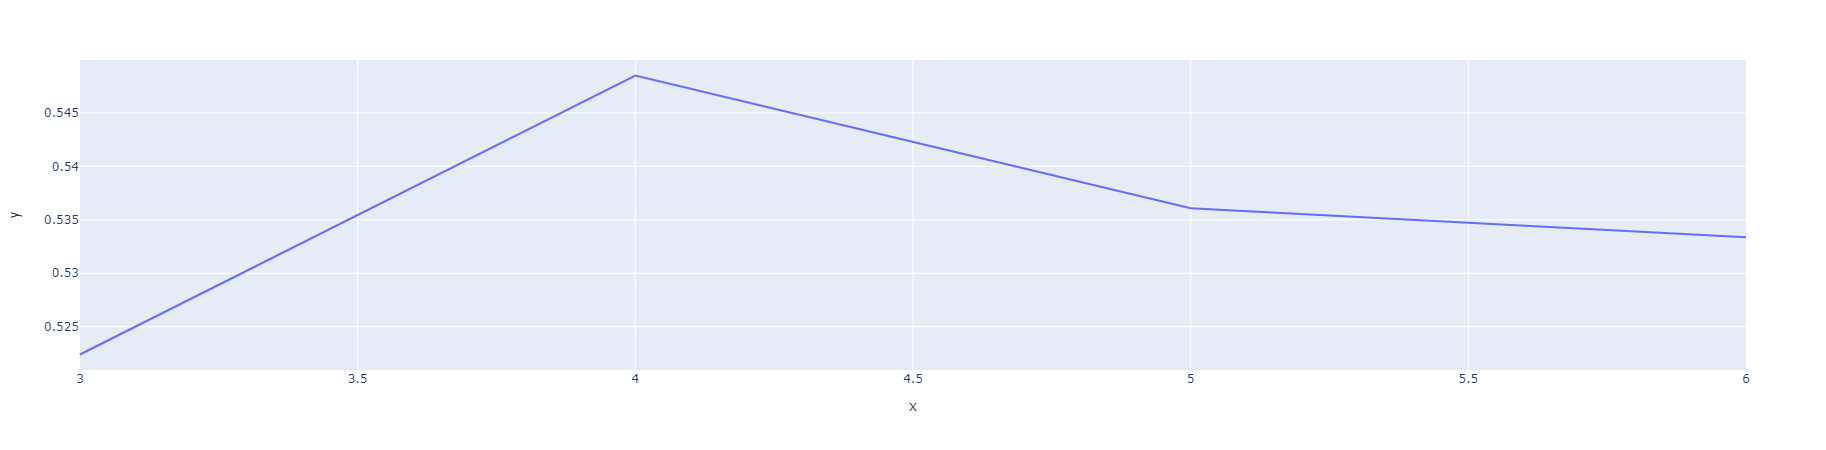

In [42]:
fig = px.line(x=wls, y=accs)
fig.show()

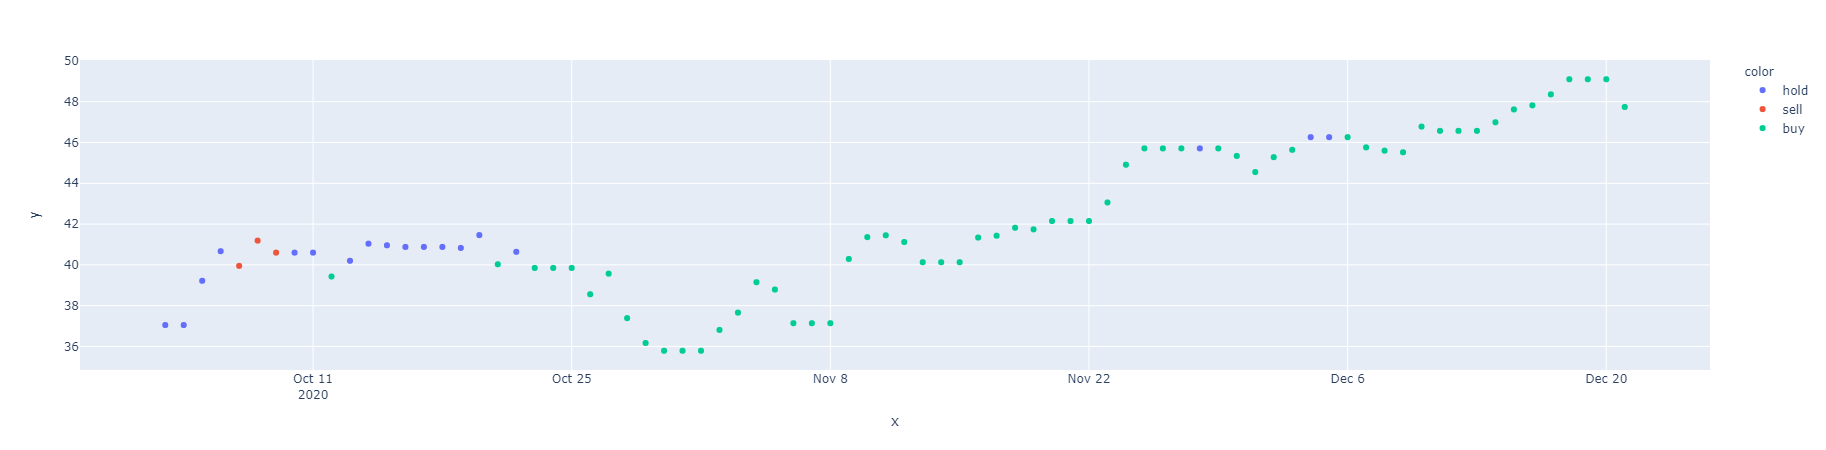

In [264]:
fig = px.scatter(x=test.index, y=test.target, color=Y_test)
fig.show()

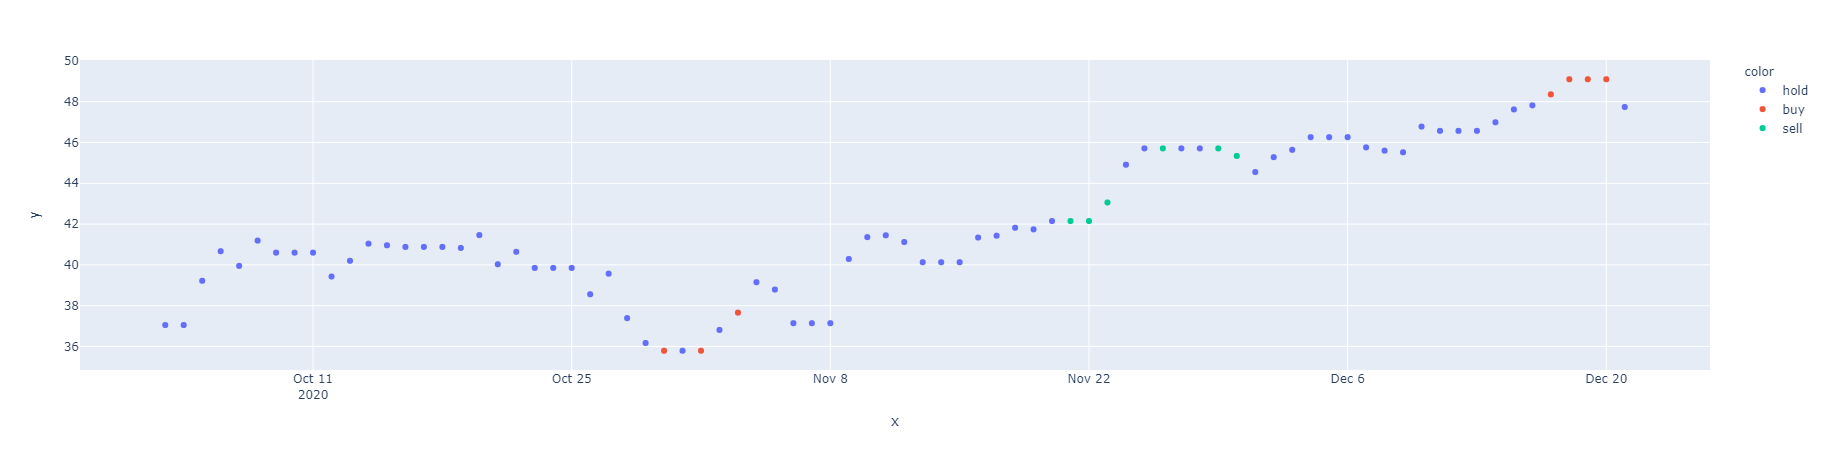

In [265]:
fig = px.scatter(x=test.index, y=test.target, color=y_pred)
fig.show()